(引用：https://axross-recipe.com/recipes/114)

In [ ]:
!pip3 install nltk
!pip3 install numpy
!pip3 install Pillow
!pip3 install pycocotools

In [ ]:
import nltk
import pickle
import os
import numpy as np
from PIL import Image
from collections import Counter
from pycocotools.coco import COCO
import glob
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms
import torch.utils.data as data


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
!mkdir data
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P ./data/
!wget http://images.cocodataset.org/zips/train2014.zip -P ./data/

!unzip ./data/annotations_trainval2014.zip -d ./data/
!rm ./data/annotations_trainval2014.zip
!unzip ./data/train2014.zip -d ./data/
!rm ./data/train2014.zip


ストリーミング出力は最後の 5000 行に切り捨てられました。
 extracting: ./data/train2014/COCO_train2014_000000408557.jpg  
 extracting: ./data/train2014/COCO_train2014_000000013714.jpg  
 extracting: ./data/train2014/COCO_train2014_000000194043.jpg  
 extracting: ./data/train2014/COCO_train2014_000000219859.jpg  
 extracting: ./data/train2014/COCO_train2014_000000278135.jpg  
 extracting: ./data/train2014/COCO_train2014_000000141015.jpg  
 extracting: ./data/train2014/COCO_train2014_000000280923.jpg  
 extracting: ./data/train2014/COCO_train2014_000000200024.jpg  
 extracting: ./data/train2014/COCO_train2014_000000435713.jpg  
 extracting: ./data/train2014/COCO_train2014_000000249993.jpg  
 extracting: ./data/train2014/COCO_train2014_000000424160.jpg  
 extracting: ./data/train2014/COCO_train2014_000000142761.jpg  
 extracting: ./data/train2014/COCO_train2014_000000532668.jpg  
 extracting: ./data/train2014/COCO_train2014_000000564904.jpg  
 extracting: ./data/train2014/COCO_train2014_000000346384.jpg  
 extract

In [ ]:
!ls

data  models  pretrained_model.zip  sample_data  surf.jpg  vocap.zip


In [ ]:
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

def make_vocab(json, threshold):
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized captions.".format(i+1, len(ids)))

    words = [word for word, cnt in counter.items() if cnt >= threshold]

    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab



In [ ]:
vocab = make_vocab(json='./data/annotations/captions_val2014.json', threshold=4)
vocab_path = './data/vocab.pkl'
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
print("Total vocabulary size: {}".format(len(vocab)))
print("Saved vocabulary wrapper to '{}'".format(vocab_path))


loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
[1000/202654] Tokenized captions.
[2000/202654] Tokenized captions.
[3000/202654] Tokenized captions.
[4000/202654] Tokenized captions.
[5000/202654] Tokenized captions.
[6000/202654] Tokenized captions.
[7000/202654] Tokenized captions.
[8000/202654] Tokenized captions.
[9000/202654] Tokenized captions.
[10000/202654] Tokenized captions.
[11000/202654] Tokenized captions.
[12000/202654] Tokenized captions.
[13000/202654] Tokenized captions.
[14000/202654] Tokenized captions.
[15000/202654] Tokenized captions.
[16000/202654] Tokenized captions.
[17000/202654] Tokenized captions.
[18000/202654] Tokenized captions.
[19000/202654] Tokenized captions.
[20000/202654] Tokenized captions.
[21000/202654] Tokenized captions.
[22000/202654] Tokenized captions.
[23000/202654] Tokenized captions.
[24000/202654] Tokenized captions.
[25000/202654] Tokenized captions.
[26000/202654] Tokenized captions.
[27000/202654] T

In [ ]:
def resize_image(image, size):
    return image.resize((size,size), Image.ANTIALIAS)

def resize_images(image_dir, output_dir, size):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        with open(os.path.join(image_dir, image), 'r+b') as f:
            with Image.open(f) as img:
                img = resize_image(img, size)
                img.save(os.path.join(output_dir, image), img.format)
        if (i+1) % 100 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i+1, num_images, output_dir))

image_dir = './data/train2014/'
output_dir = './data/resized2014/'
image_size = 256
resize_images(image_dir, output_dir, image_size)


<ipython-input-40-8126f537beed>:2: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  return image.resize((size,size), Image.ANTIALIAS)


[100/82783] Resized the images and saved into './data/resized2014/'.
[200/82783] Resized the images and saved into './data/resized2014/'.
[300/82783] Resized the images and saved into './data/resized2014/'.
[400/82783] Resized the images and saved into './data/resized2014/'.
[500/82783] Resized the images and saved into './data/resized2014/'.
[600/82783] Resized the images and saved into './data/resized2014/'.
[700/82783] Resized the images and saved into './data/resized2014/'.
[800/82783] Resized the images and saved into './data/resized2014/'.
[900/82783] Resized the images and saved into './data/resized2014/'.
[1000/82783] Resized the images and saved into './data/resized2014/'.
[1100/82783] Resized the images and saved into './data/resized2014/'.
[1200/82783] Resized the images and saved into './data/resized2014/'.
[1300/82783] Resized the images and saved into './data/resized2014/'.
[1400/82783] Resized the images and saved into './data/resized2014/'.
[1500/82783] Resized the imag

In [ ]:
!ls ./data

annotations  resized2014  train2014  vocab.pkl


In [ ]:
class CocoDataset(data.Dataset):
    def __init__(self, root, json, vocab, transform=None):
        self.root = root
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        coco = self.coco
        vocab = self.vocab
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.ids)


In [ ]:
def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    images = torch.stack(images, 0)

    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths

def get_loader(root, json, vocab, transform, batch_size, shuffle, num_workers):
    coco = CocoDataset(root=root,
                       json=json,
                       vocab=vocab,
                       transform=transform)

    data_loader = torch.utils.data.DataLoader(dataset=coco,
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)

    return data_loader


In [ ]:
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super(Encoder, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


In [ ]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length

    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs

    def predict(self, features, states=None):
        predicted_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))
            _, predicted = outputs.max(1)
            predicted_ids.append(predicted)
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)
        predicted_ids = torch.stack(predicted_ids, 1)
        return predicted_ids

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_path = 'models/'
crop_size = 224
vocab_path = 'data/vocab.pkl'
image_dir ='data/resized2014'
caption_path='data/annotations/captions_train2014.json'
log_step=10
save_step=1000
embed_size=256
hidden_size=512
num_layers=1
num_epochs=10
batch_size=128
num_workers=2
learning_rate=0.001

if not os.path.exists(model_path):
    os.makedirs(model_path)

transform = transforms.Compose([
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

with open(vocab_path, 'rb') as f:
  vocab = pickle.load(f)

data_loader = get_loader(image_dir, caption_path, vocab, transform, batch_size,
                          shuffle=True, num_workers=num_workers)

encoder = Encoder(embed_size).to(device)
decoder = Decoder(embed_size, hidden_size, len(vocab), num_layers).to(device)

criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, captions, lengths) in enumerate(data_loader):

        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, num_epochs, i, total_step, loss.item(), np.exp(loss.item())))

        if (i+1) % save_step == 0:
            torch.save(decoder.state_dict(), os.path.join(
                model_path, 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            torch.save(encoder.state_dict(), os.path.join(
                model_path, 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))


FileNotFoundError: ignored

In [ ]:
!pip uninstall googletrans
!pip install googletrans==4.0.0-rc1

Found existing installation: googletrans 4.0.0rc1
Uninstalling googletrans-4.0.0rc1:
  Would remove:
    /usr/local/bin/translate
    /usr/local/lib/python3.10/dist-packages/googletrans-4.0.0rc1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/googletrans/*
Proceed (Y/n)? y
  Successfully uninstalled googletrans-4.0.0rc1
  Using cached googletrans-4.0.0rc1-py3-none-any.whl


In [ ]:
!wget 'https://tensorflow.org/images/surf.jpg'

--2023-09-21 12:59:54--  https://tensorflow.org/images/surf.jpg
Resolving tensorflow.org (tensorflow.org)... 216.239.32.27, 2001:4860:4802:32::1b
Connecting to tensorflow.org (tensorflow.org)|216.239.32.27|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.tensorflow.org/images/surf.jpg [following]
--2023-09-21 12:59:54--  https://www.tensorflow.org/images/surf.jpg
Resolving www.tensorflow.org (www.tensorflow.org)... 74.125.130.100, 74.125.130.138, 74.125.130.102, ...
Connecting to www.tensorflow.org (www.tensorflow.org)|74.125.130.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64400 (63K) [image/jpeg]
Saving to: ‘surf.jpg.1’

surf.jpg.1          100%[===================>]  62.89K   185KB/s    in 0.3s    

2023-09-21 12:59:55 (185 KB/s) - ‘surf.jpg.1’ saved [64400/64400]



In [ ]:
!rm models

In [ ]:
!rm *.pkl
!rm *.zip

In [ ]:
!mkdir models

In [ ]:
!ls

models	sample_data  surf.jpg


In [ ]:
!wget https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip
!unzip pretrained_model.zip
!mv encoder-5-3000.pkl decoder-5-3000.pkl models
!wget https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip
!unzip vocap.zip
!mv vocab.pkl models

--2023-09-21 12:59:55--  https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ne0ixz5d58ccbbz/pretrained_model.zip [following]
--2023-09-21 12:59:56--  https://www.dropbox.com/s/raw/ne0ixz5d58ccbbz/pretrained_model.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucca483d36b5bc5267e4947ba7f3.dl.dropboxusercontent.com/cd/0/inline/CEIKtxRVCrVL7nY9xAHqAvzBOJD8JcfD2_Un-1hdvFGE-dwJMBst0oujB_XyVbJyQKg4XZpq8nupDmdcRdF0BSIg9pY551emjIDgmyyJKjK1SPRu2EXjm9gz7HkGe9JR72zDp9MaZR1VnZWKOZdn3UWr/file# [following]
--2023-09-21 12:59:56--  https://ucca483d36b5bc5267e4947ba7f3.dl.dropboxusercontent.com/cd/0/inline/CEIKtxRVCrVL7nY9xAHqAvzBOJD8JcfD2_Un-1hdvFGE-dwJMBst0oujB_XyVbJyQKg4XZpq8nu

In [ ]:
!ls models/

decoder-5-3000.pkl  encoder-5-3000.pkl	vocab.pkl


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:09<00:00, 25.7MB/s]


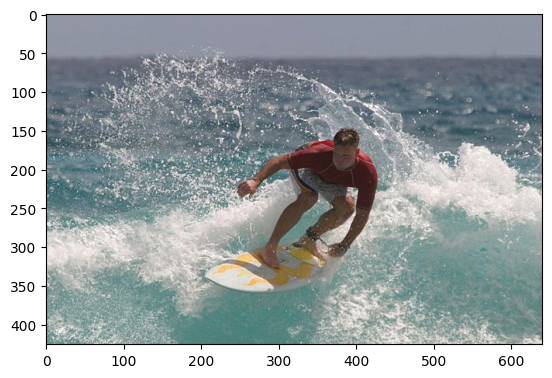

a man riding a wave on a surfboard in the ocean
海のサーフボードで波に乗っている男


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        image = transform(image).unsqueeze(0)

    return image

encoder_path ='models/encoder-5-3000.pkl'
decoder_path ='models/decoder-5-3000.pkl'
vocab_path ='models/vocab.pkl'

embed_size=256
hidden_size=512
num_layers=1

image_path = './surf.jpg'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

with open(vocab_path, 'rb') as f:
  vocab = pickle.load(f)

encoder = Encoder(embed_size).eval()
decoder = Decoder(embed_size, hidden_size, len(vocab), num_layers)
encoder = encoder.to(device)
decoder = decoder.to(device)

encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

image = load_image(image_path, transform)
image_tensor = image.to(device)

feature = encoder(image_tensor)
predicted_ids = decoder.predict(feature)
predicted_ids = predicted_ids[0].cpu().numpy()

predicted_caption = []
for word_id in predicted_ids:
    word = vocab.idx2word[word_id]
    predicted_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(predicted_caption[1:-2])

from googletrans import Translator
translator = Translator()
translation = translator.translate(sentence, dest='ja')

image = Image.open(image_path)
plt.imshow(np.asarray(image))
plt.show()
print (sentence)
print(translation.text)